# Step 1: Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
!pip install xgboost lightgbm catboost
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


# Step 2: Data Preparation

In [3]:
# Import the dataset
train_data_df = pd.read_csv('/content/heart_disease_uci.csv')

# Display 5 random samples of the dataset.
train_data_df.sample(10)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
507,508,47,Male,Hungary,non-anginal,140.0,193.0,False,normal,145.0,True,1.0,flat,NaN,NaN,1
215,216,56,Male,Cleveland,typical angina,120.0,193.0,False,lv hypertrophy,162.0,False,1.9,flat,0.0,reversable defect,0
466,467,55,Male,Hungary,non-anginal,120.0,220.0,False,lv hypertrophy,134.0,False,0.0,NaN,NaN,NaN,0
35,36,42,Male,Cleveland,asymptomatic,140.0,226.0,False,normal,178.0,False,0.0,upsloping,0.0,normal,0
867,868,55,Male,VA Long Beach,asymptomatic,NaN,204.0,True,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,1
826,827,50,Male,VA Long Beach,asymptomatic,144.0,349.0,False,lv hypertrophy,120.0,True,1.0,upsloping,NaN,reversable defect,1
294,295,63,Female,Cleveland,asymptomatic,124.0,197.0,False,normal,136.0,True,0.0,flat,0.0,normal,1
231,232,55,Female,Cleveland,asymptomatic,180.0,327.0,False,st-t abnormality,117.0,True,3.4,flat,0.0,normal,2
62,63,58,Male,Cleveland,asymptomatic,128.0,216.0,False,lv hypertrophy,131.0,True,2.2,flat,3.0,reversable defect,1
738,739,63,Male,VA Long Beach,asymptomatic,126.0,0.0,False,st-t abnormality,120.0,False,1.5,downsloping,NaN,NaN,0


## PART 3: Data Exploration

### Step 3.1 Get information about columns and data types.

In [4]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


#### The dataset contains 920 rows, and at a glance, there a some missing data, as can be seen in trestbps and chol columns among others. It has a mixture of int, float and object types. There would be some processing, scaling and standardization later on.

### 3.2: Shape

In [5]:
train_data_df.shape

(920, 16)

#### 920 rows and 16 columns.

### 3.3 Stats

In [6]:
train_data_df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


### 3.4 Missing values.

In [7]:
missing_data = train_data_df.isnull().sum()
percent_missing = (missing_data / len(train_data_df)) * 100
print(pd.DataFrame({'Missing Values': missing_data, 'Percentage': percent_missing}))


          Missing Values  Percentage
id                     0    0.000000
age                    0    0.000000
sex                    0    0.000000
dataset                0    0.000000
cp                     0    0.000000
trestbps              59    6.413043
chol                  30    3.260870
fbs                   90    9.782609
restecg                2    0.217391
thalch                55    5.978261
exang                 55    5.978261
oldpeak               62    6.739130
slope                309   33.586957
ca                   611   66.413043
thal                 486   52.826087
num                    0    0.000000


#### A significant proportion is missing. 'ca' and 'thal' will be dropped as over 50% of it is missing. Trying to impute it will potentially introduce significant noise and bias in the dataset.

### 3.5: Further analysis.

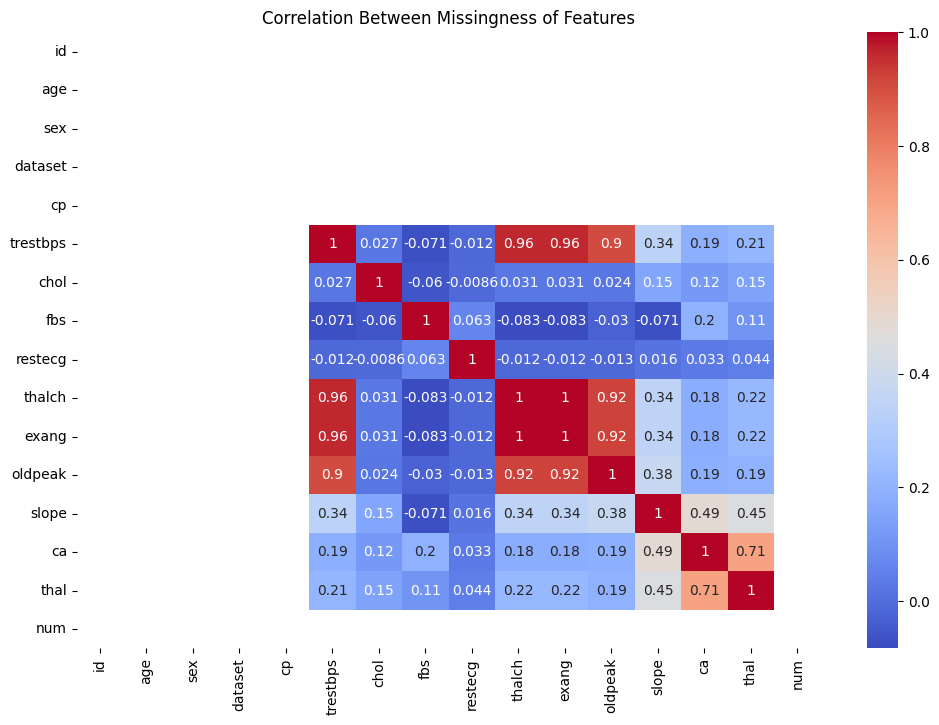

In [8]:
# Create a binary DataFrame indicating where values are missing
missing_flags = train_data_df.isnull().astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(missing_flags.corr(), cmap="coolwarm", annot=True)
plt.title("Correlation Between Missingness of Features")
plt.savefig('missing-corr.png')
plt.show()

#### This has revealed strong missingness correlation between trestbps, thalach, exang, and oldpeak, suggesting shared source or diagnostic dependency. As said earlier, 'ca' and 'thal' will be dropped and the rest will be imputed.

### 3.6 Drop columns with more than 50% missing data.

In [9]:
train_data_df = train_data_df.drop(columns=['ca', 'thal'])

### 3.7 Let's take a look at the target column

In [10]:
print(train_data_df['num'].value_counts(normalize=True) * 100)  # Show percentages

num
0    44.673913
1    28.804348
2    11.847826
3    11.630435
4     3.043478
Name: proportion, dtype: float64


##### We'll convert all values greater than 1 to 1 to signal presence of heart disease.

In [11]:
train_data_df['num'] = train_data_df['num'].apply(lambda x: 1 if x > 0 else 0)

### 3.8 Understanding relationships.

In [12]:
def heart_disease_corr(type, col_name):
    #count occurrences.
    _disease_counts = train_data_df.groupby([type, 'num'])['id'].count().reset_index()

    #rename columns for clarity.
    _disease_counts.columns = [col_name, 'Heart Disease', 'Count']

    #plot a grouped bar chart.
    plt.figure(figsize=(8, 6))
    sns.barplot(data=_disease_counts, x=col_name, y='Count', hue='Heart Disease', palette=['green', 'red'])

    plt.title(f'Distribution of {col_name} and Heart Disease')
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.legend(title='Presence of heart disease: green = no, red = yes')
    plt.tight_layout()
    plt.show()

#### 3.8.1 General heart disease distribution

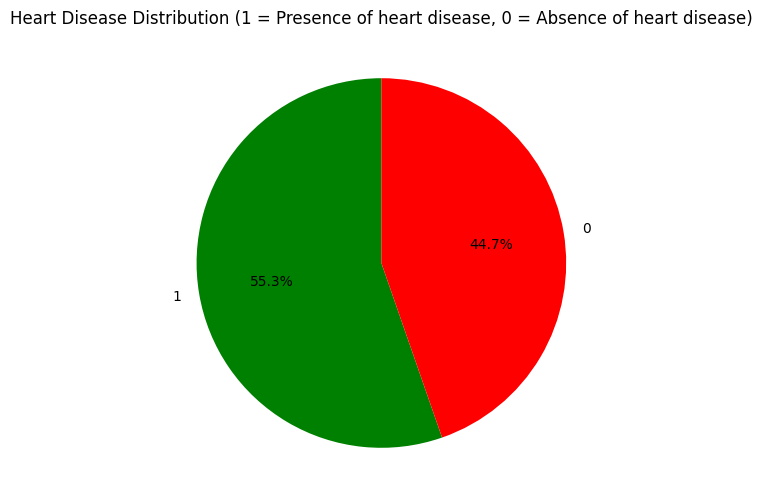

In [13]:
#calculate the disease rate.
disease_counts = train_data_df['num'].value_counts()

#plot the pie chart.
plt.figure(figsize=(6, 6))
plt.pie(disease_counts, labels=disease_counts.index, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Heart Disease Distribution (1 = Presence of heart disease, 0 = Absence of heart disease)')
plt.show()

##### We have a fairly balanced distribution with slightly higher heart disease occurrence.

#### 3.8.2 Relationship between gender and heart disease

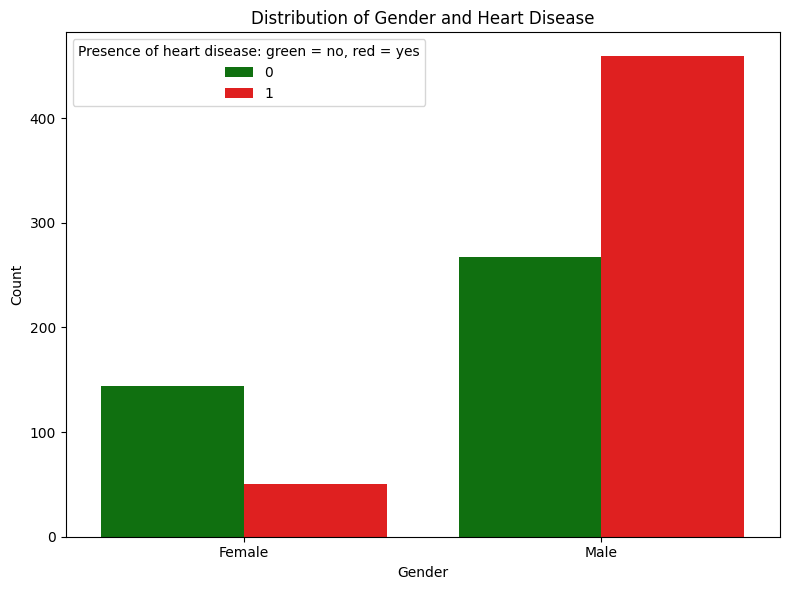

In [14]:
heart_disease_corr("sex", "Gender")

##### The dataset contains predominantly males, who also predominantly have heart diseases compared to females.

### 3.8.3 General chest pain distribution

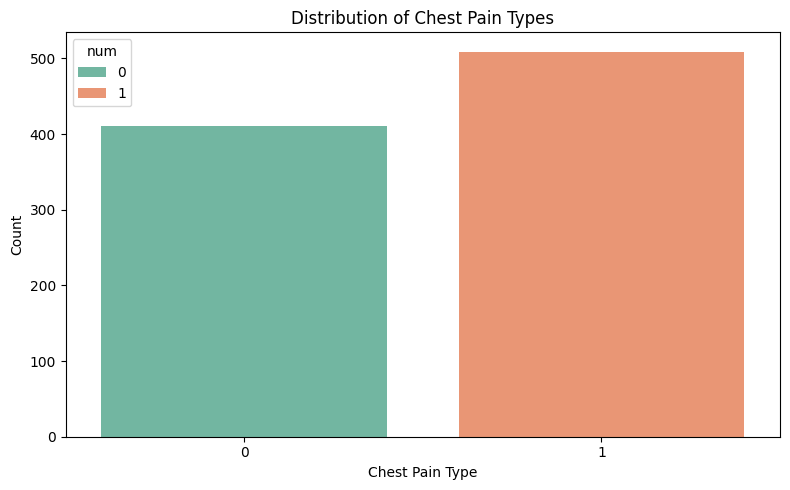

In [15]:
chest_pain_count = train_data_df['num'].value_counts()

# Bar chart for chest pain types
plt.figure(figsize=(8, 5))
sns.barplot(x=chest_pain_count.index, y=chest_pain_count.values, hue=chest_pain_count.index, palette='Set2')

plt.title('Distribution of Chest Pain Types')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### More than half of the chest pain types is the asymptomatic type.

### 3.8.4 Relationship between chest pain type and heart disease.

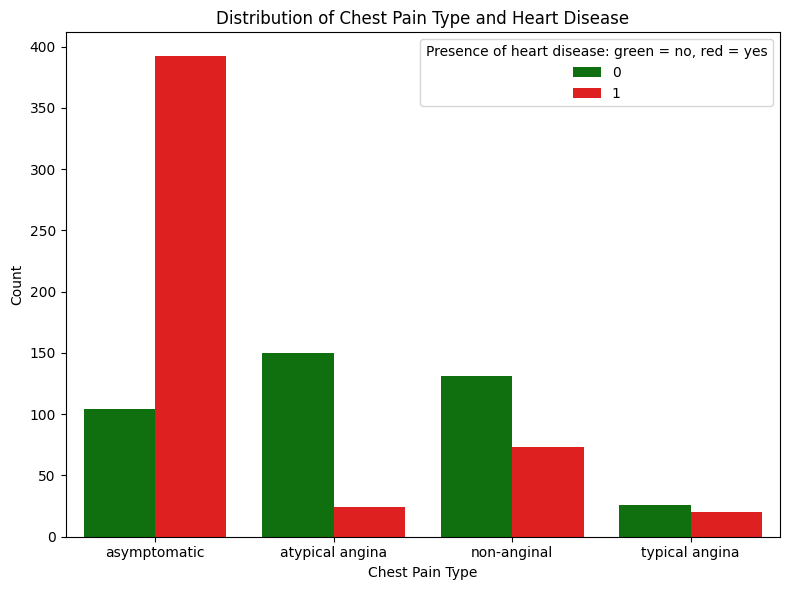

In [16]:
heart_disease_corr("cp", "Chest Pain Type")

#### As was expected, chest pain of the asymptomatic type has the highest prevalence of heart disease.

#### 3.8.5 Relationship between cholesterol level and heart disease

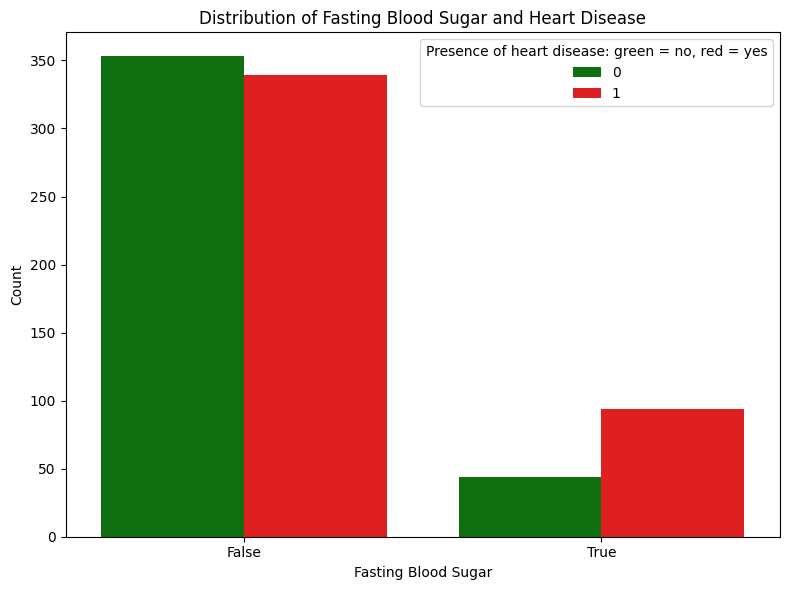

In [17]:
heart_disease_corr("fbs", "Fasting Blood Sugar")

#### In majority of the cases where there is heart disease, the fasting blood sugar was greater than 120 mg/dl.

### 3.8.6 Relationship between cholesterol and heart disease

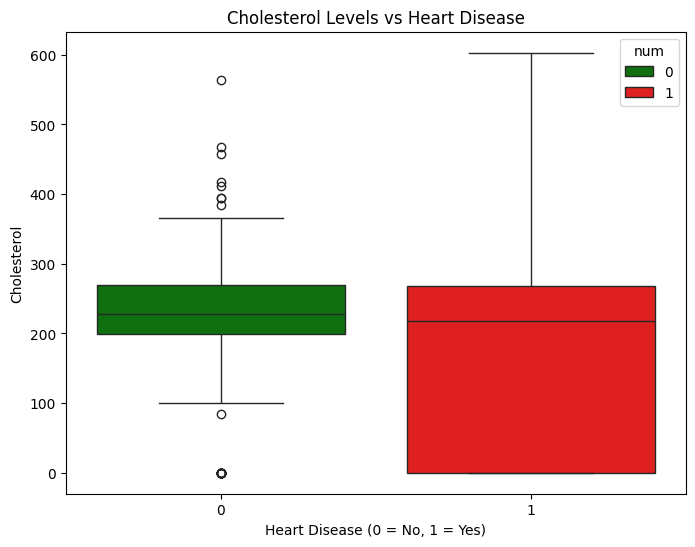

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='num', y='chol', data=train_data_df, hue='num', palette={0: 'green', 1: 'red'})
plt.title('Cholesterol Levels vs Heart Disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Cholesterol')
plt.show()

#### There is a greater variation in cholesterol is higher among people with heart disease.

### 3.8.7 Relationship between age and heart disease

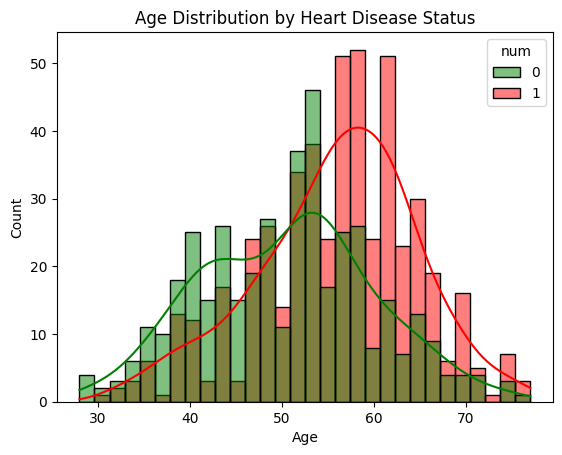

In [19]:
sns.histplot(data=train_data_df, x='age', hue='num', kde=True, bins=30, palette={0: 'green', 1: 'red'})
plt.title('Age Distribution by Heart Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


#### - Heart disease tends to occur more often in the 55–65 age range.
#### - People without heart disease are slightly more frequent in younger ages (40–50).
#### - Age is correlated with heart disease: it becomes more common in older individuals.

### 3.9 Encode categorical columns.

In [20]:
label_encoder = LabelEncoder()
categorical_cols = ['sex', 'cp', 'fbs','dataset','exang','slope','restecg']

for col in categorical_cols:
    train_data_df[col] = label_encoder.fit_transform(train_data_df[col])